```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018, 2019 Norwegian Meteorological Institute

Here, we create some examples to explore possible inconsistencies
in the beta model approximation.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Beta approximation bug investigation


## Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import os
import datetime
import gc
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(6.0, 4.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import  CDKLM16, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
width = 500000
height = 500000

domain_min = 16
domain_max = int(256/4)
    
g = 9.81
r = 0.00
f = 1.0e-4
beta = 1.0e-11

end_time = 1600.0

------- changing y ------
Angle: Max=0.98279, min=-0.46365, sum=0.9732518284
Angle: Max=0.98279, min=-0.46365, sum=0.4846467832
Angle: Max=0.98279, min=-0.46365, sum=0.2418540942
Angle: Max=0.98279, min=-0.46365, sum=0.1208127349
Angle: Max=0.98279, min=-0.46365, sum=0.0603781556
------- changing x ------
Angle: Max=0.98279, min=-0.46365, sum=0.9592963265
Angle: Max=0.98279, min=-0.46365, sum=0.4823897044
Angle: Max=0.98279, min=-0.46365, sum=0.2418540942
Angle: Max=0.98279, min=-0.46365, sum=0.1210887720
Angle: Max=0.98279, min=-0.46365, sum=0.0605844421
------- changing x open bc ------
[-5.72222222e+00 -5.60991637e+00 -5.49761051e+00 -5.38530466e+00
 -5.27299881e+00 -5.16069295e+00 -5.04838710e+00 -4.93608124e+00
 -4.82377539e+00 -4.71146953e+00 -4.59916368e+00 -4.48685783e+00
 -4.37455197e+00 -4.26224612e+00 -4.14994026e+00 -4.03763441e+00
 -3.92532855e+00 -3.81302270e+00 -3.70071685e+00 -3.58841099e+00
 -3.47610514e+00 -3.36379928e+00 -3.25149343e+00 -3.13918757e+00
 -3.02688172e+

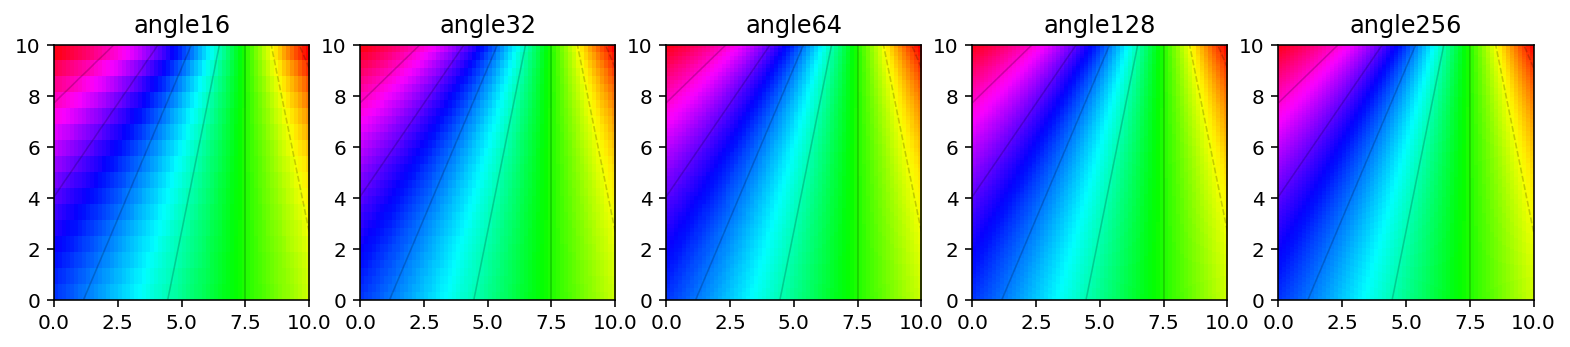

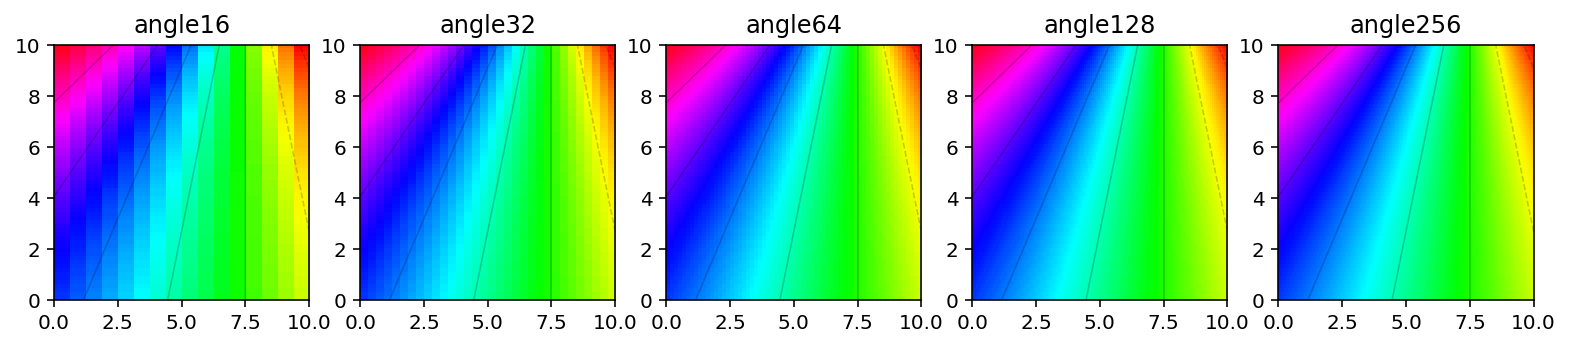

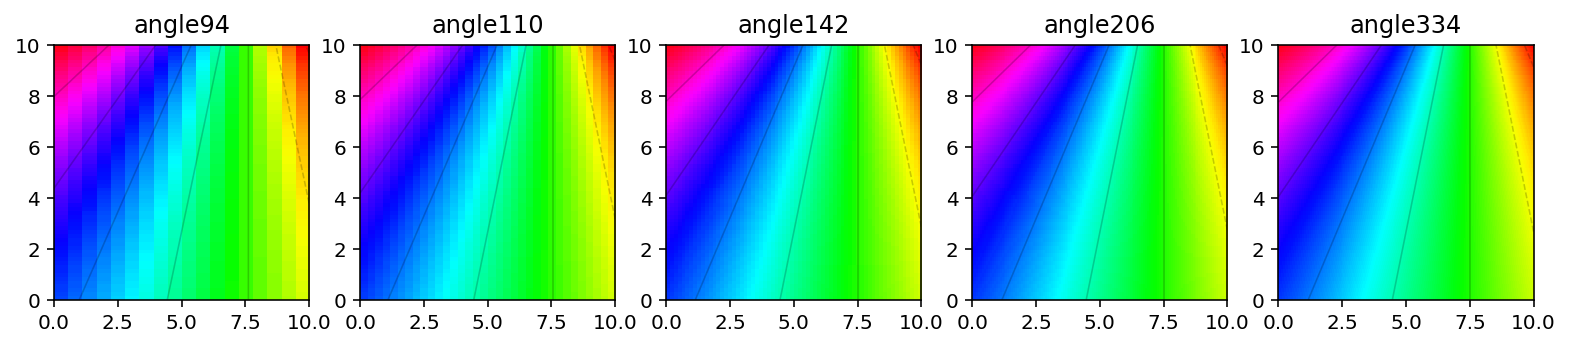

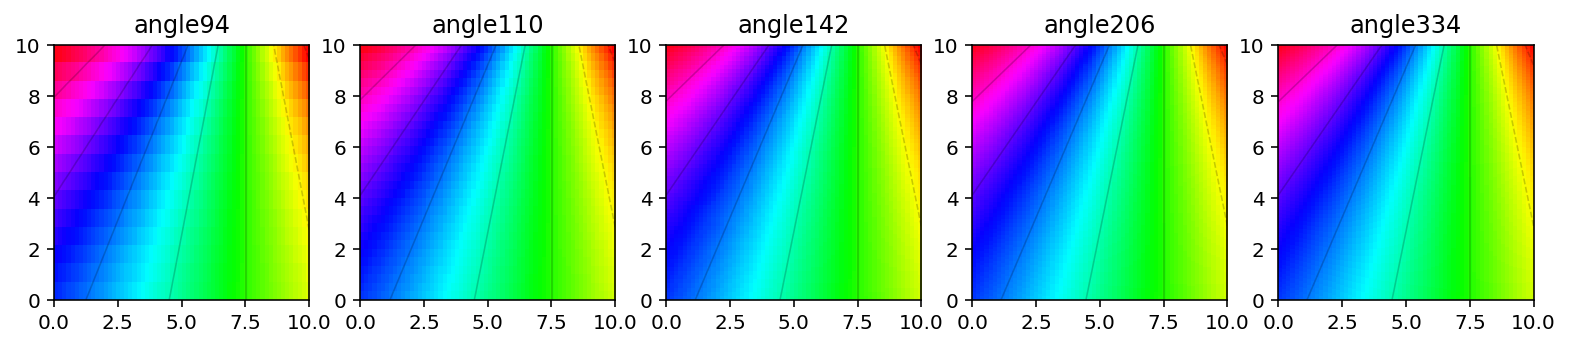

In [4]:

def initAngle(angle, sponge=0):
    ny, nx = angle.shape
    
    ny_int = ny - 2*sponge
    nx_int = nx - 2*sponge
    
    #North pole
    x0 = 0.5
    y0 = 2.0
    
    
    
    #Vector to north
    x = np.linspace(-1, 1, nx) - x0
    y = np.linspace(-1, 1, ny) - y0
    
    if sponge > 0:
        
        dx = 2/nx_int
        dy = 2/ny_int
        x_start = -1 - sponge*dx
        x_end   =  1 + sponge*dx
        y_start = -1 - sponge*dy
        y_end   =  1 + sponge*dy
        
        x = np.linspace(x_start, x_end, nx) - x0
        y = np.linspace(y_start, y_end, ny) - y0

        if (nx_int < 30):
            print(x)
        #x = np.linspace(-1 - sponge/(2*nx_int), 1+sponge/(2*nx_int), nx) - x0
        #y = np.linspace(-1 - sponge/(2*ny_int), 1+sponge/(2*ny_int), ny) - y0
        #x = np.linspace(-1 - (2*sponge-2)/(nx_int), 1+(2*sponge-2)/(nx_int), nx) - x0
        #y = np.linspace(-1 - (2*sponge-2)/(ny_int), 1+(2*sponge-2)/(ny_int), ny) - y0

    x, y = np.meshgrid(x, y)
    
    #Normalize
    l = np.sqrt(x**2 + y**2)
    x = x/l
    y = y/l
    
    angle.fill(-np.pi/2)
    angle = angle + np.arccos(x)
    
    return angle
    
print('------- changing y ------')
plt.figure(figsize=(16,4))
for i in range(5):
    domain_size = domain_min*2**i
    angle = np.empty((domain_size, domain_max))
    angle = initAngle(angle)
    plt.subplot(1, 6, i+1)
    plt.imshow(angle, interpolation='None', origin='lower', extent=[0,10,0,10], cmap=plt.cm.hsv)
    plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8, extent=[0,10,0,10])
    #plt.quiver(np.sin(angle[::4, ::4]), np.cos(angle[::4, ::4]), color='r')
    #plt.quiver(np.cos(angle[::4, ::4]), -np.sin(angle[::4, ::4]), color='g')
    plt.title("angle"+str(domain_size))
    print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))
    
    
print('------- changing x ------')    
plt.figure(figsize=(16,4))
for i in range(5):
    domain_size = domain_min*2**i
    angle = np.empty((domain_max, domain_size))
    angle = initAngle(angle)
    plt.subplot(1, 6, i+1)
    plt.imshow(angle, interpolation='None', origin='lower', extent=[0,10,0,10], cmap=plt.cm.hsv)
    plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8, extent=[0,10,0,10])
    #plt.quiver(np.sin(angle[::4, ::4]), np.cos(angle[::4, ::4]), color='r')
    #plt.quiver(np.cos(angle[::4, ::4]), -np.sin(angle[::4, ::4]), color='g')
    plt.title("angle"+str(domain_size))
    print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))
    
print('------- changing x open bc ------')
plt.figure(figsize=(16,4))
for i in range(5):
    domain_size = domain_min*2**i + 40*2-2
    angle = np.empty((domain_max + 40*2-2, domain_size))
    angle = initAngle(angle, sponge=38)
    angle = angle[38:-38, 38:-38]
    plt.subplot(1, 6, i+1)
    #plt.imshow(angle, interpolation='None', origin='lower', cmap=plt.cm.hsv)
    #plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8)
    plt.imshow(angle, interpolation='None', origin='lower', extent=[0,10,0,10], cmap=plt.cm.hsv)
    plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8, extent=[0,10,0,10])
    #plt.quiver(np.sin(angle[::4, ::4]), np.cos(angle[::4, ::4]), color='r')
    #plt.quiver(np.cos(angle[::4, ::4]), -np.sin(angle[::4, ::4]), color='g')
    plt.title("angle"+str(domain_size))
    print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))
    
print('------- changing y open bc ------')
plt.figure(figsize=(16,4))
for i in range(5):
    domain_size = domain_min*2**i + 40*2-2
    angle = np.empty((domain_size, domain_max + 40*2-2))
    angle = initAngle(angle, sponge=40)
    angle = angle[40:-40, 40:-40]
    plt.subplot(1, 6, i+1)
    #plt.imshow(angle, interpolation='None', origin='lower', cmap=plt.cm.hsv)
    #plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8)
    plt.imshow(angle, interpolation='None', origin='lower', extent=[0,10,0,10], cmap=plt.cm.hsv)
    plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8, extent=[0,10,0,10])
    #plt.quiver(np.sin(angle[::4, ::4]), np.cos(angle[::4, ::4]), color='r')
    #plt.quiver(np.cos(angle[::4, ::4]), -np.sin(angle[::4, ::4]), color='g')
    plt.title("angle"+str(domain_size))
    print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))
    
    

    

## Running different cases

In [5]:

def runCDKLM(domain_size, change_x=True, challenging_bc=False, plot=False):
    #Clean up old simulator if any:
    if 'sim' in globals():
        sim.cleanUp()

    nx = domain_size
    ny = domain_size

    if change_x:
        ny = domain_max
    else:
        nx = domain_max

    dx = float(width/nx)
    dy = float(height/ny)

    bc = Common.BoundaryConditions()
    ghosts = np.array([2,2,2,2])
    sponge = 0
    
    if challenging_bc:
        sponge = 40

        ghosts = np.array([sponge,sponge,sponge,sponge])
        bc = Common.BoundaryConditions(3,3,3,3, spongeCells=ghosts)
        
    
    dataShape = (ny + ghosts[1]+ghosts[3], 
                 nx + ghosts[0]+ghosts[2])

    Hi = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*10
    eta0 = np.zeros(dataShape, dtype=np.float32);
    hu0 = np.zeros(dataShape, dtype=np.float32);
    hv0 = np.ones(dataShape, dtype=np.float32)*2;
    
    angle = np.zeros(dataShape, dtype=np.float32);
    angle = initAngle(angle, sponge=sponge)
    
    #angle = np.zeros((ny, nx), dtype=np.float32)
    #angle = initAngle(angle)
    
    print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))

    #Initialize simulator
    sim = CDKLM16.CDKLM16(gpu_ctx, 
                                eta0, hu0, hv0, Hi, 
                                nx, ny, 
                                dx, dy, 0, 
                                g, f, r,
                                rk_order=1,
                                angle=angle,
                                boundary_conditions=bc)

    t = sim.step(sim.dt)


    eta1, hu1, hv1 = sim.download(interior_domain_only=True)
    #print("eta: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta1), np.min(eta1), np.sum(eta1/(domain_size*domain_size))))

    eta1_complete, hu1_complete, hv1_complete = sim.download(interior_domain_only=False)
    #print("eta: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta1), np.min(eta1), np.sum(eta1/(domain_size*domain_size))))

    if plot:
        def imshow(data, title):
            fig = plt.figure(figsize=(6,5))
            plt.imshow(data, origin='lower', interpolation=None)
            plt.colorbar()
            plt.title(title)
            
        imshow(eta1, 'eta1')
        imshow(hu1, 'hu1')
        imshow(hv1, 'hv1')
    
    if change_x:
        x = np.arange(dx/2, width, dx)

        # Cross section at upper 3/4:
        fx = hu1[int(3*ny/4), :]

        if challenging_bc:
            x_complete =  np.arange(-39.5*dx, width + 40*dx, dx)
            fx_complete =  hu1_complete[40+int(3*ny/4), :]
            return [x, fx, x_complete, fx_complete]
            
        return [x, fx]

    else:
        y = np.arange(dy/2, width, dy)

        # Cross section at leftmost 1/4:
        fy = hu1[:, int(1*nx/4)]
        
        if challenging_bc:
            y_complete =  np.arange(-39.5*dy, width + 40*dy, dy)
            fy_complete =  hu1_complete[:, 40+int(1*nx/4)]
            
            print("------", y_complete.shape, fy_complete.shape)
            return [y, fy, y_complete, fy_complete]

        return [y, fy]


#Run all domain sizes 
vary_x_data = {}
vary_y_data = {}
vary_x_open = {}
vary_y_open = {}
vary_x_open_complete = {}
vary_y_open_complete = {}
domain_size = domain_min




while (domain_size <= domain_max):
    print('domain_size', domain_size)
    [x, fx] = runCDKLM(domain_size, change_x=True)
    [y, fy] = runCDKLM(domain_size, change_x=False)

    vary_x_data[str(domain_size)] = [x, fx]
    vary_y_data[str(domain_size)] = [y, fy]
    
    [x, fx, x_complete, fx_complete] = runCDKLM(domain_size, change_x=True, challenging_bc=True)
    [y, fy, y_complete, fy_complete] = runCDKLM(domain_size, change_x=False, challenging_bc=True)

    vary_x_open[str(domain_size)] = [x, fx]
    vary_y_open[str(domain_size)] = [y, fy]
    
    vary_x_open_complete[str(domain_size)] = [x_complete, fx_complete]
    vary_y_open_complete[str(domain_size)] = [y_complete, fy_complete]
    
    
    
    
    domain_size = domain_size*2

    
print('done')

domain_size 16
Angle: Max=0.98279, min=-0.46365, sum=1.2768849529
Angle: Max=0.98279, min=-0.46365, sum=1.2906603157
[-6.5        -6.37368421 -6.24736842 -6.12105263 -5.99473684 -5.86842105
 -5.74210526 -5.61578947 -5.48947368 -5.36315789 -5.23684211 -5.11052632
 -4.98421053 -4.85789474 -4.73157895 -4.60526316 -4.47894737 -4.35263158
 -4.22631579 -4.1        -3.97368421 -3.84736842 -3.72105263 -3.59473684
 -3.46842105 -3.34210526 -3.21578947 -3.08947368 -2.96315789 -2.83684211
 -2.71052632 -2.58421053 -2.45789474 -2.33157895 -2.20526316 -2.07894737
 -1.95263158 -1.82631579 -1.7        -1.57368421 -1.44736842 -1.32105263
 -1.19473684 -1.06842105 -0.94210526 -0.81578947 -0.68947368 -0.56315789
 -0.43684211 -0.31052632 -0.18421053 -0.05789474  0.06842105  0.19473684
  0.32105263  0.44736842  0.57368421  0.7         0.82631579  0.95263158
  1.07894737  1.20526316  1.33157895  1.45789474  1.58421053  1.71052632
  1.83684211  1.96315789  2.08947368  2.21578947  2.34210526  2.46842105
  2.594

# Check results

These plots only make sense if you change the CDKLM kernel to 
```
hu_row[ti] = angle;
```


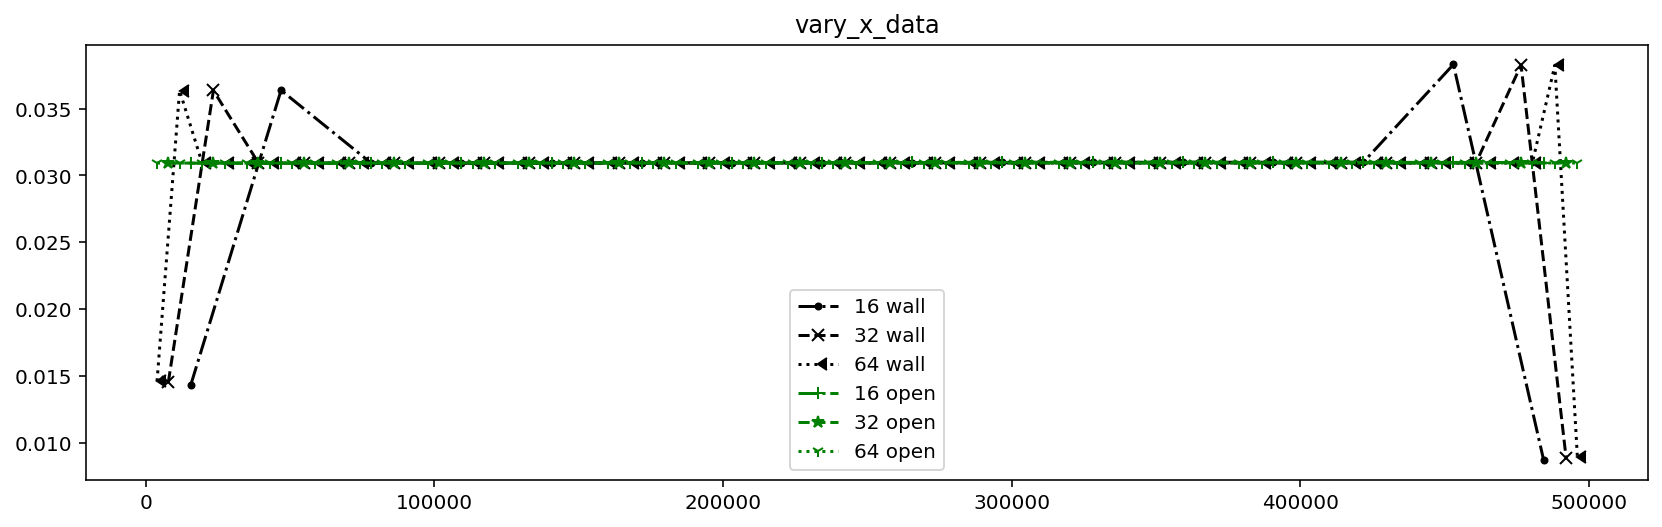

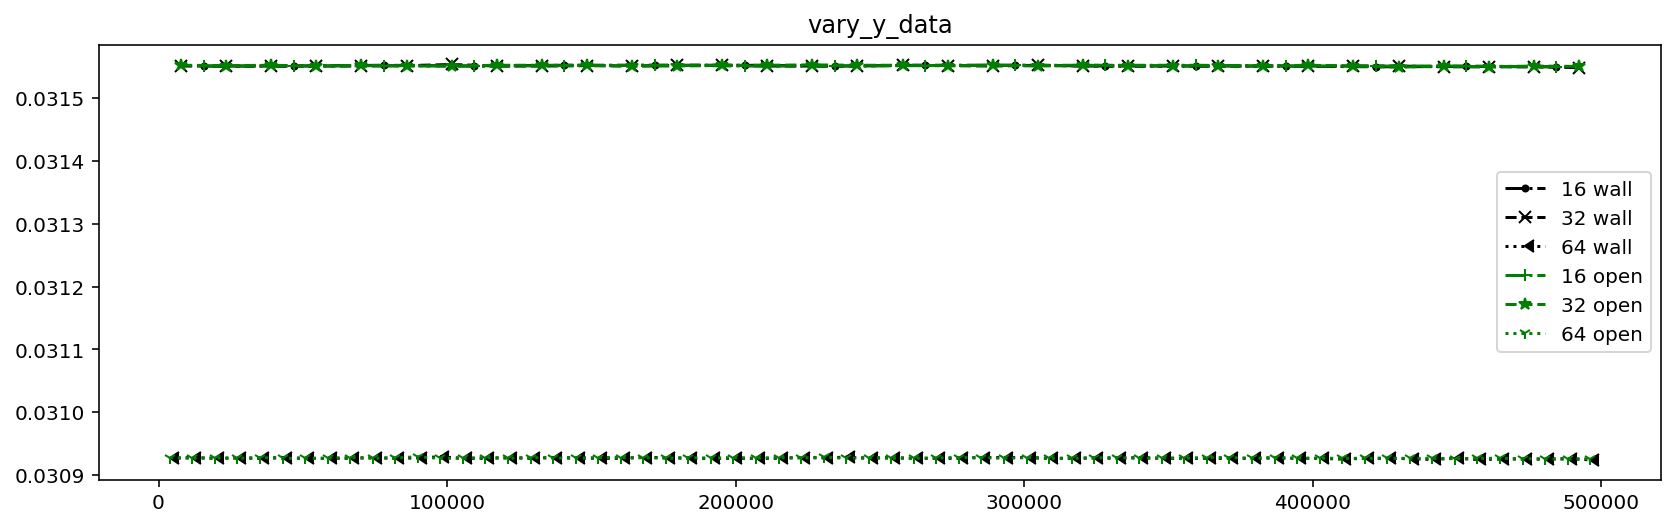

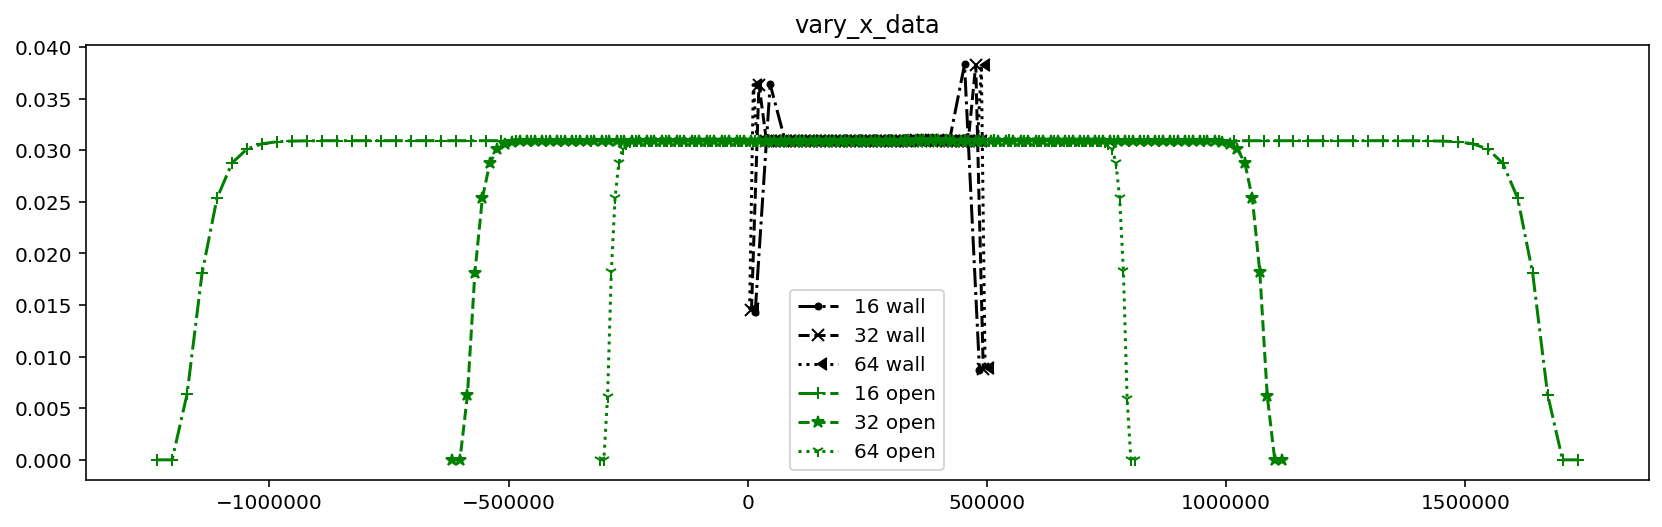

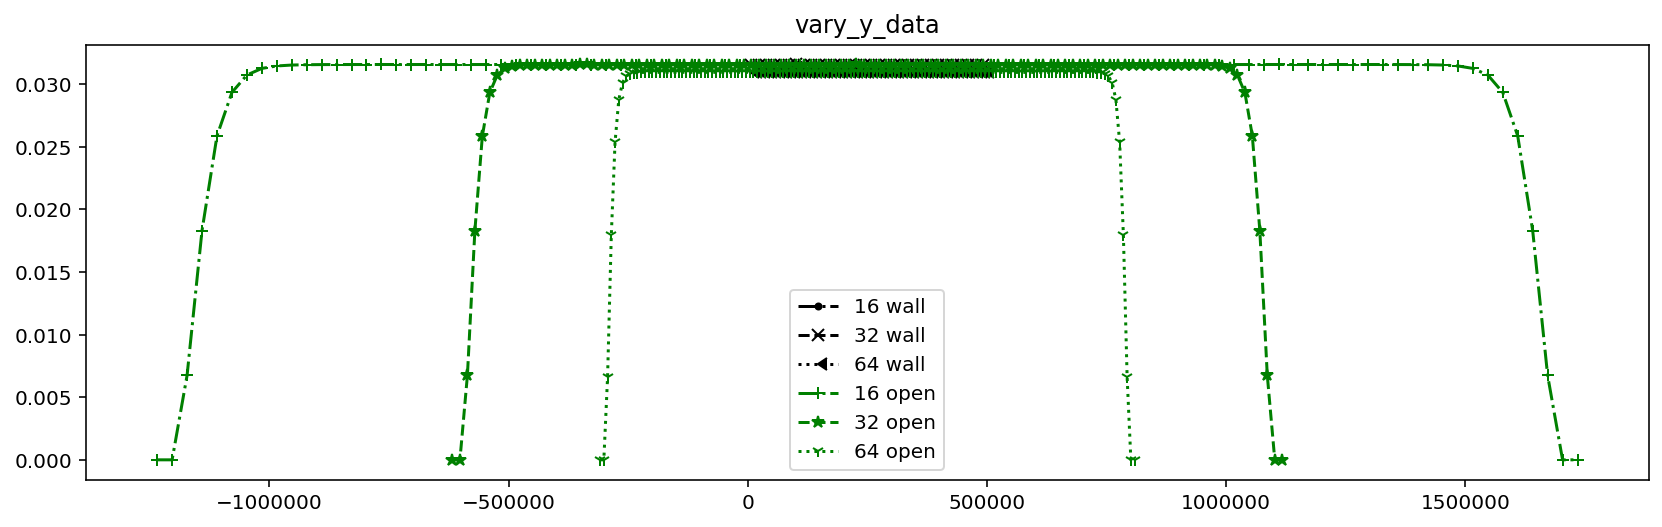

In [6]:
def setStyles(ax, color='k'):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'g', 'g', 'g']) )
    

def check_results(wall_data_set, open_data_set, title):
    
    fig = plt.figure(figsize=(14,4))
    setStyles(fig.gca())
    
    for name, vals in wall_data_set.items():
        plt.plot(vals[0], vals[1], label=name+" wall")
    for name, vals in open_data_set.items():
        plt.plot(vals[0], vals[1], label=name+" open")
    
    
    plt.legend()
    plt.title(title)

check_results(vary_x_data, vary_x_open, 'vary_x_data')
check_results(vary_y_data, vary_y_open, 'vary_y_data')

check_results(vary_x_data, vary_x_open_complete, 'vary_x_data')
check_results(vary_y_data, vary_y_open_complete, 'vary_y_data')

    
 

        
#check_results(vary_x_data, 'vary_x_data')
#check_results(vary_y_data, 'vary_y_data')
#check_results(vary_x_open, 'vary_x_open')
#check_results(vary_y_open, 'vary_y_open')


# Great illustration of how a local beta model gives a wierd Coriolis force when the angle varies substantially across the domain

Initial conditions are
```
eta = 0
hu = 0
hv = 2
```
with open boundary conditions towards a zero external state.

The results are after one RK1 step, with hu and hv illustrating the strength of the Coriolis force

Angle: Max=1.57016, min=-1.56980, sum=1.0318675176


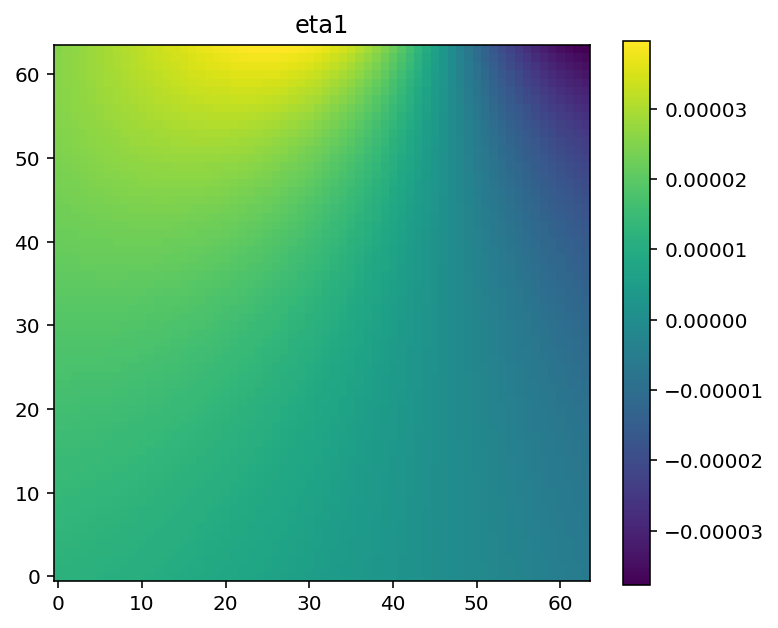

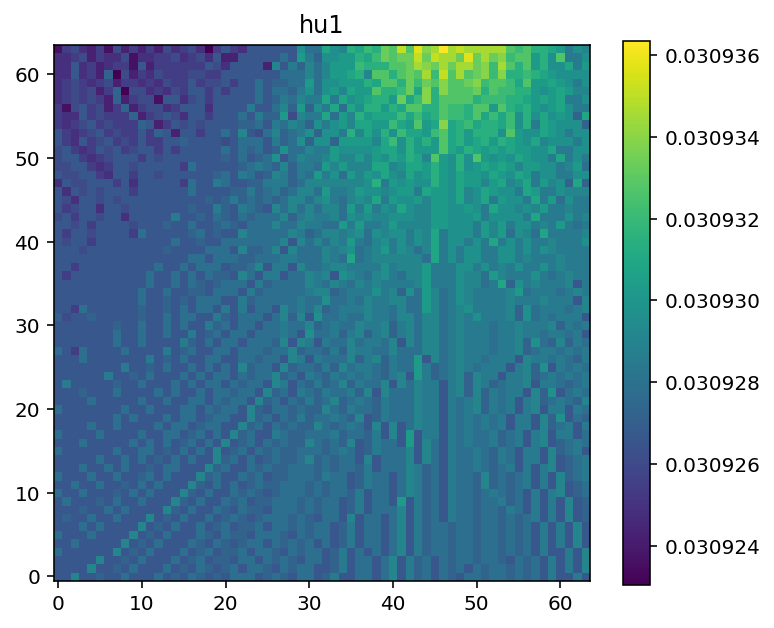

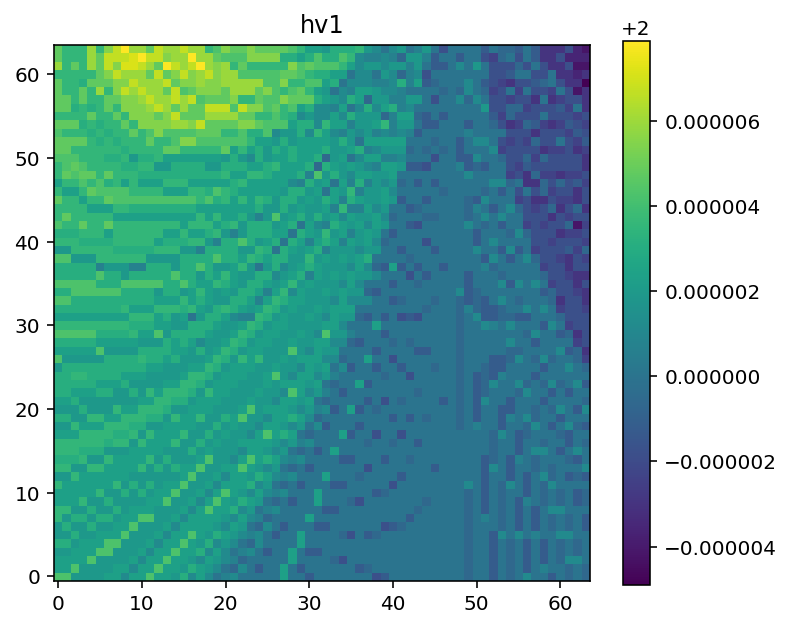

In [7]:
dummy_data = runCDKLM(64, change_x=True, challenging_bc=True, plot=True)
